<a href="https://colab.research.google.com/github/cpappas18/Articulaite/blob/main/Final_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


SMOTE Function 

In [52]:
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE
from numpy import where, random

def smote_multiclass(df, num_samples_dict, one_hot_encoded):
  """
  Performs data augmentation and/or downsampling on a dataframe with multiple classes.
  Supports both numerical and one-hot encoded class values.
  The SMOTE algorithm is used for augmentation and random sampling is used for downsampling of the specified classes.
  Keyword arguments:
  df -- the dataframe to manipulate
  num_samples_dict -- a dictionary of the form {0: num_desired_samples, 1: num_desired_samples, ...} that indicates the
                      number of samples that the returned dataframe should have in each class
  one_hot_encoded -- Boolean value indicating if the dataframe is one-hot encoded
  """

  if df.columns[[0]] == 'Unnamed: 0':
    df.drop(df.columns[[0]], axis=1, inplace=True)  # remove first column

  # change one hot encoded dataset into numerical labels
  if one_hot_encoded:
    df.insert(loc=0, column='Status', value=np.nan)
    for i, row in df.iterrows():
      if df.iloc[i]['Control'] == 1:
          status = 0
      elif df.iloc[i]['Parkinsons'] == 1:
          status = 1
      elif df.iloc[i]['ALS'] == 1:
          status = 2
      elif df.iloc[i]['Cerebral_palsy'] == 1:
          status = 3
      df.at[i,'Status'] = status
    df = df.drop(columns=['Control', 'Parkinsons', 'ALS', 'Cerebral_palsy'])


  if num_samples_dict is not None:
    strategy = num_samples_dict

    # downsampling classes if needed
    counter = Counter(df.Status)
    class_samples = []
    for i in range(4):
      if counter[i] > num_samples_dict[i]: # class i needs to be downsampled
        class_i = df.loc[df['Status'] == i]
        class_i_sample = class_i.sample(n=num_samples_dict[i])
        class_samples.append(class_i_sample)
      else: # class i does not need downsampling
        class_i = df.loc[df['Status'] == i]
        class_samples.append(class_i)

    df = pd.concat(class_samples).reset_index(drop=True)

  else:
    strategy = 'auto'

  y = df.Status # labels
  x = df.drop(['Status', 'Gender'], axis=1) # features only, Gender also removed because it must be binary
  gender = df.Gender

  oversample = SMOTE(sampling_strategy=strategy)
  x_oversampled, y_oversampled = oversample.fit_resample(x, y)

  # get sample counts for augmented dataset
  counter = Counter(y_oversampled)

  if num_samples_dict is not None and (counter[0] != num_samples_dict[0] or counter[1] != num_samples_dict[1]
                                       or counter[2] != num_samples_dict[2] or counter[3] != num_samples_dict[3]):
    print("Sampling failed")
  elif num_samples_dict is None and (counter[0] != counter[1] or counter[1] != counter[2] or counter[2] != counter[3]):
    print("Sampling failed")

  # regenerate dataframe with new samples
  df_concat = pd.concat([pd.DataFrame(y_oversampled), pd.DataFrame(gender), pd.DataFrame(x_oversampled)], axis=1)
  df_concat.columns = df.columns

  # fill missing gender values with a random choice of 0 or 1
  for row in df_concat.loc[df_concat.Gender.isnull(), 'Gender'].index:
    df_concat.at[row, 'Gender'] = random.randint(0, 2)

  # change numerical class values back into one-hot encoded values
  if one_hot_encoded:
    one_hot = pd.get_dummies(df_concat['Status'])
    one_hot.rename(columns={0:'Control', 1:'Parkinsons', 2:'ALS', 3:'Cerebral_palsy'}, inplace=True)
    df_concat = df_concat.drop(columns=['Status'], axis=1)
    df_concat = pd.concat([one_hot, df_concat], axis=1)

  return df_concat

Function to get TP, TN, FP ,FN 

In [53]:
#function to get TP,TN,FP,FN
def perf_measure(y_actual, y_hat):
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    #0=HC, 1= PD, 2 = ALS, 3= CP
    for i in range(len(y_hat)): 
        #actually positive and predicts positive 
        if y_actual[i]==y_hat[i] and y_actual[i] != 0:
           TP += 1
           #actually healthy but predicted otherwise 
        elif y_actual[i]==0 and y_hat[i]!=y_actual[i]:
           FP += 1
           #actuall negative and predicts neg
        elif y_actual[i]== 0 and y_hat[i]==y_actual[i]:
           TN += 1
           #actual positive but predicts negative 
        elif y_actual[i] !=0 and y_hat[i] == 0:
           FN += 1
    return TP, FP, TN, FN

Performance Report function 

In [54]:
import csv
import matplotlib.pyplot as plt
import os
import secrets  # to generate jpg name

def performance_report(model, X, y, X_test, y_test, y_pred, model_label):

  # classification accuracy
  try:
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, y_pred)
  except:
    accuracy = "NA"

  # confusion matrix
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import plot_confusion_matrix
  from sklearn.model_selection import cross_val_score, KFold
  
  try:
    conf = confusion_matrix(y_test, y_pred)
    TP = conf[1][1]
    TN = conf[0][0]
    FP = conf[0][1]
    FN = conf[1][0]

    disp = plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, values_format='.0f')
    title = secrets.token_hex(4)
    plt.savefig(title, format="jpg")

    path1 = os.path.abspath(title+".jpg")
  except:
    TP = TN = FP = FN = path1 = ""

  # k-fold cross validation
  from sklearn import model_selection
  try:
    kfold = model_selection.KFold(n_splits=6, shuffle=True)
    KCV = model_selection.cross_val_score(model, X, y, cv=kfold, scoring='accuracy').mean()
  except:
    KCV = ""

  # log loss (closer to 0 is better)
  try:
    logloss = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_log_loss').mean()
  except:
    logloss = ""

  # AUC (1 is perfect predictions, 0.5 is as good as random)
  try:
    AUC = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring='roc_auc').mean()
  except:
    AUC = ""

  # precision recall curve
  from sklearn.metrics import plot_precision_recall_curve
  from sklearn.metrics import average_precision_score

  try:
    y_score = model.decision_function(X_test)
    average_precision = average_precision_score(y_test, y_score)

    disp = plot_precision_recall_curve(model, x_test, y_test)
    title = secrets.token_hex(4)  
    plt.savefig(title, format="jpg")

    path2 = os.path.abspath(title+".jpg")
  except:
    average_precision = path2 = ""

  # appending metrics to csv file
  with open('metrics.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    if os.stat("metrics.csv").st_size == 0:
      writer.writerow(["Model label", "Accuracy score", "TP", "TN", "FP", "FN", "Confusion matrix file","KCV", "Log-loss", "AUC", "Average precision", "Precision-recall file"])
    writer.writerow([model_label, accuracy, TP, TN, FP, FN, path1, KCV, logloss, AUC, average_precision, path2])

Importing dataset 

In [55]:
import pandas as pd
data = pd.read_csv('all_disorders_median_std.csv')
data.tail()

,Status,Gender,MDVP:Jitter(%),MDVP:Jitter(Abs),Jitter:PPQ5,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,DFA
7114,0,1,-33.243298,-21.578308,-24.440050,-32.691854,-23.328592,-7.466749,-14.202938,-10.933402,-23.923671,-23.417656
7115,0,1,-1.091966,18.936385,-2.803416,-3.468182,-1.064890,-2.724605,0.447177,4.317949,-4.380995,-1.267387
7116,0,1,36.342110,-0.576181,43.847541,31.416897,-17.235723,1.363223,-16.826345,-16.550963,-19.062965,-14.755758
7117,0,1,2.882944,-3.402288,1.476280,7.581402,-18.794885,-2.917623,-20.237481,-26.715980,-28.921770,-19.716314
7118,0,1,-4.331071,21.605465,-19.186196,-16.242616,21.702316,5.115358,28.461133,15.115793,18.373862,-11.029646


Dividing into features and labels 

In [56]:
features = data.drop(['Status'], axis = 1)
labels = data.drop(['Gender', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'Jitter:PPQ5', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'DFA'],axis = 1)

In [57]:
X = features 
Y = labels 
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

Getting the training set to perform SMOTE on 

In [58]:
pre_smote_training_dataset_median = pd.concat([Y_train, X_train], axis=1, join='inner')

In [59]:
pre_smote_training_dataset_median

,Status,Gender,MDVP:Jitter(%),MDVP:Jitter(Abs),Jitter:PPQ5,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,DFA
1939,1,1,-0.012823,-0.000285,-0.013156,0.004770,-0.292665,-0.654569,-0.162217,-0.193538,-0.244500,-0.742457
3097,1,0,-0.043461,-0.000321,-0.022637,-0.060669,0.121519,0.155280,0.124605,0.020994,0.020007,-0.483428
4154,1,0,-0.055367,-0.000430,-0.029835,-0.100071,-0.081678,-0.176022,-0.096327,-0.067921,0.054373,-0.303763
6613,1,1,-0.033307,-0.000335,-0.021232,-0.103369,0.155645,0.284119,0.083679,0.113747,0.254219,1.733804
4801,1,0,-0.010197,0.000045,-0.010347,-0.023350,-0.377746,-0.735554,-0.225389,-0.251258,-0.282449,0.632832
...,...,...,...,...,...,...,...,...,...,...,...,...
88,1,0,-0.021051,-0.000201,-0.011752,-0.017795,0.464802,1.138142,0.320575,0.336954,-0.102311,0.866027
2219,1,0,-0.053966,-0.000419,-0.031590,-0.075597,-0.379148,-0.842307,-0.212483,-0.257430,-0.338315,-0.857949
2389,1,0,-0.011072,0.000163,-0.010698,-0.040708,-0.168628,-0.382166,-0.080534,-0.092778,-0.102474,0.554150
1519,1,0,-0.017375,-0.000095,-0.008065,-0.045394,-0.360138,-0.776047,-0.214011,-0.240081,-0.304926,0.541296


In [60]:
pre_smote_training_dataset_median.reset_index(inplace = True)
pre_smote_training_dataset_median.drop(['index'],axis = 1, inplace = True)

In [61]:
pre_smote_training_dataset_median

,Status,Gender,MDVP:Jitter(%),MDVP:Jitter(Abs),Jitter:PPQ5,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,DFA
0,1,1,-0.012823,-0.000285,-0.013156,0.004770,-0.292665,-0.654569,-0.162217,-0.193538,-0.244500,-0.742457
1,1,0,-0.043461,-0.000321,-0.022637,-0.060669,0.121519,0.155280,0.124605,0.020994,0.020007,-0.483428
2,1,0,-0.055367,-0.000430,-0.029835,-0.100071,-0.081678,-0.176022,-0.096327,-0.067921,0.054373,-0.303763
3,1,1,-0.033307,-0.000335,-0.021232,-0.103369,0.155645,0.284119,0.083679,0.113747,0.254219,1.733804
4,1,0,-0.010197,0.000045,-0.010347,-0.023350,-0.377746,-0.735554,-0.225389,-0.251258,-0.282449,0.632832
...,...,...,...,...,...,...,...,...,...,...,...,...
5690,1,0,-0.021051,-0.000201,-0.011752,-0.017795,0.464802,1.138142,0.320575,0.336954,-0.102311,0.866027
5691,1,0,-0.053966,-0.000419,-0.031590,-0.075597,-0.379148,-0.842307,-0.212483,-0.257430,-0.338315,-0.857949
5692,1,0,-0.011072,0.000163,-0.010698,-0.040708,-0.168628,-0.382166,-0.080534,-0.092778,-0.102474,0.554150
5693,1,0,-0.017375,-0.000095,-0.008065,-0.045394,-0.360138,-0.776047,-0.214011,-0.240081,-0.304926,0.541296


Doing SMOTE on the training set 

In [62]:
smoted_training_data_median = smote_multiclass(pre_smote_training_dataset_median, num_samples_dict={0:6000, 1:6000, 2:6000, 3:6000}, one_hot_encoded=False)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (6000) in class 0 will be larger than the number of samples in the majority class (class #1 -> 5365)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (6000) in class 1 will be larger than the number of samples in the majority class (class #1 -> 5365)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (6000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 5365)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (6000) in class 3 will be larger than the number of samples in the majority class (class #1 -> 5365)
  n_sam

In [63]:
smoted_training_data_median

,Status,Gender,MDVP:Jitter(%),MDVP:Jitter(Abs),Jitter:PPQ5,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,DFA
0,0,0.0,-0.066046,-0.000553,-0.042299,-0.113437,0.594138,1.108693,0.397842,0.471245,0.429959,0.881539
1,0,1.0,-0.053091,-0.000271,-0.024743,-0.094517,0.115130,0.225221,0.023903,0.110744,0.413835,1.038028
2,0,0.0,-0.076463,-0.000475,-0.024317,-0.129319,-0.104194,-0.306702,-0.025819,-0.043399,-0.108386,-1.158067
3,0,1.0,-0.076463,-0.000560,-0.026780,-0.129319,-0.280791,-0.628838,-0.152299,-0.171384,-0.247953,-1.118315
4,0,0.0,-0.090557,-0.000692,-0.050375,-0.137738,0.236518,0.545480,0.171305,0.175805,0.167570,-0.159349
...,...,...,...,...,...,...,...,...,...,...,...,...
23995,3,0.0,-1.720904,-6.250975,0.428600,2.978906,-16.338208,-5.168954,-16.250771,-17.034300,-16.651903,2.697227
23996,3,0.0,0.369451,-10.099027,0.796307,4.196481,-11.811699,-1.817727,-14.062947,-13.053548,-11.577223,0.206325
23997,3,0.0,8.461369,-7.594139,6.790427,13.815745,1.791773,-1.358804,3.857816,10.322011,14.189717,-4.571306
23998,3,0.0,-1.085191,-7.904161,2.186310,0.969982,1.886047,-1.368098,3.108355,4.420190,-2.248656,-3.007468


Dividing smoted training set into features and labels to train the model on 

In [64]:
new_X_train_median = smoted_training_data_median.drop(['Status'], axis = 1)
new_Y_train_median = smoted_training_data_median.drop(['Gender', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'Jitter:PPQ5', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'DFA'],axis = 1)

In [65]:
model2 = RandomForestClassifier(n_estimators=100, max_depth=70, bootstrap=True, max_features='sqrt', min_samples_leaf=1, min_samples_split=3)
model2.fit(new_X_train_median, new_Y_train_median)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=70, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Calculating Metrics 

In [66]:
Y_pred = model2.predict(X_test)

In [67]:
from sklearn import metrics
print(metrics.classification_report(Y_pred, Y_test))

              precision    recall  f1-score   support

           0       0.97      0.59      0.74       127
           1       0.96      1.00      0.98      1294
           2       0.67      1.00      0.80         2
           3       0.33      1.00      0.50         1

    accuracy                           0.96      1424
   macro avg       0.73      0.90      0.75      1424
weighted avg       0.96      0.96      0.96      1424



In [69]:
from itertools import chain
roc_auc_score(Y_test, model2.predict_proba(X_test), multi_class='ovr')

0.9967156215474401

In [68]:
print(accuracy_score(Y_test, Y_pred)*100)

96.20786516853933


In [70]:
Y_pred_list = Y_pred.tolist()

Y_test_list = Y_test.values.tolist()

#changing from 2d list into 1d list 
Y_test_list = list(chain.from_iterable(Y_test_list))

TP,FP, TN, FN = perf_measure(Y_test_list, Y_pred_list)

In [73]:
print(FN)

52


In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(model2, new_X_train_median, new_Y_train_median, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

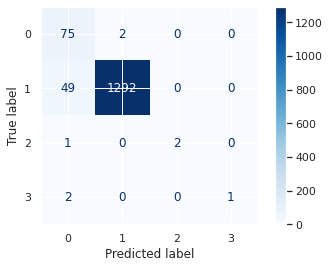

In [72]:
model_label = 'Randomforest_alldisorders_median'
performance_report(model2, new_X_train_median, new_Y_train_median, X_test, Y_test, Y_pred, model_label)

Saving the model to a file 

In [76]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(model2, open(filename, 'wb'))

In [77]:
loaded_model = pickle.load(open(filename, 'rb'))